<a href="https://colab.research.google.com/github/felixsimard/comp551-p3/blob/main/Felix_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# Felix's Notebook for exploring the assignment

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from sklearn import preprocessing
from tqdm import tqdm
import math
import string

In [102]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [103]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(img)
    # plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

In [104]:
def get_label_value(labels):
  """
  This function will return a string representing the label of a picture given
  the array label as input:
  Ex ouput: '1a', '4z' ...
  """
  label_temp = labels.tolist()
  label_temp = [int(x) for x in label_temp]
  number = label_temp[:10].index(1)
  letter = alpha_dict[label_temp[10:].index(1)]

  return str(number) + str(letter)

In [144]:
def transform_output(scores):
    """
    Input a Tensor and output will be another Tensor with same dimension but with all elements 0 except two.
    Those 2 elements will have value of 1 and will correspond to the models prediction about which letter and number
    is in the image.
    :param scores:
    :return:
    """
    return_array = []
    score_list = scores.tolist()

    for score in score_list:
        numbers = score[:10]
        letters = score[10:]
        test = lambda x, max_value : 1 if x >= max_value else 0

        new_numbers = [test(x, max(numbers)) for x in numbers]
        new_letters = [test(x, max(letters)) for x in letters]

        return_array.append(new_numbers + new_letters)

    return return_array

In [106]:
from google.colab import drive
drive.mount("/content/drive")
def load_data(filename, data_path='/content/drive/MyDrive/P3-COMP551-FALL2021/'):
    loaded_pkl = None
    try:
        pkl_buffered = open(data_path+''+filename,'rb')
        loaded_pkl = pickle.load(pkl_buffered)
    except Exception as e:
        print("Error loading data: {}".format(e))
    return loaded_pkl
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
# Load data
train_l = load_data("images_l.pkl")
train_ul = load_data("images_ul.pkl")
train_labels_l = load_data("labels_l.pkl")
test_ul = load_data("images_test.pkl")

In [108]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            # x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
            x = self.transform(x)
        
        return x, y
    
    
    def __len__(self):
        return len(self.data)

In [109]:
# Hyper-parameters
NUM_EPOCHS = 10
BATCH_SIZE = 4
NUM_CHANNELS = 1
NUM_CLASSES = 36
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
TRAIN_TEST_SPLIT = 0.3
FLATTEN_IMG_SIZE = 3136 # 56 * 56 

In [110]:
# Tensor, Transform, Datasets, Dataloaders

# For labelizing inputs
# def labelize(lst):
#     bin_str = "".join(str(int(i)) for i in lst)
#     return bin_str

# Labels logic
# labels_l_lst = labels_l.tolist()
# labels_l_lst = [labelize(lst) for lst in labels_l_lst]
# labels_encoder = preprocessing.LabelEncoder()
# targets = labels_encoder.fit_transform(labels_l_lst)

# Flatten training data
# ?


# Split into training and validation
split_index = math.floor(len(train_labels_l)*TRAIN_TEST_SPLIT)

full_train_l = train_l
val_l = train_l[:split_index]
train_l = train_l[split_index:]

full_train_labels_l = train_labels_l
val_labels_l = train_labels_l[:split_index]
train_labels_l = train_labels_l[split_index:]

print(full_train_l.shape, full_train_labels_l.shape)
print(train_l.shape, train_labels_l.shape)
print(val_l.shape, val_labels_l.shape)

(30000, 56, 56) (30000, 36)
(21000, 56, 56) (21000, 36)
(9000, 56, 56) (9000, 36)


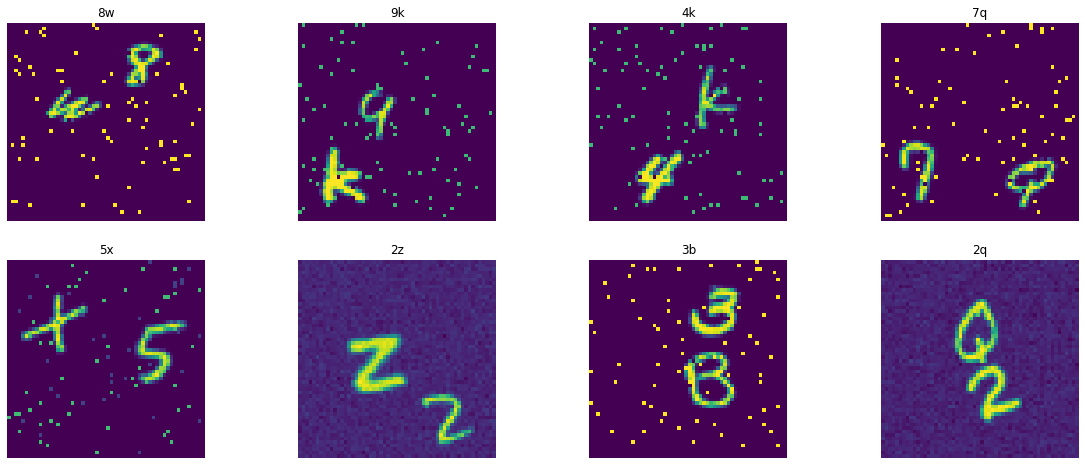

In [111]:
# Visualize some data
alpha_dict = dict(enumerate(string.ascii_lowercase))
figure = plt.figure(figsize=(20, 8))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_l), size=(1,)).item()
    img = train_l[sample_idx]
    label = get_label_value(train_labels_l[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [115]:
# Turn data and labels into Datasets then DataLoaders

# Transform function
mean = (0.5,)
std = (0.5,)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std)])

# DataLoaders
full_train_l_dataloader = DataLoader(CustomDataset(full_train_l, full_train_labels_l, transform=transform), shuffle=True, batch_size=BATCH_SIZE)
train_l_dataloader = DataLoader(CustomDataset(train_l, train_labels_l, transform=transform), shuffle=True, batch_size=BATCH_SIZE)
val_l_dataloader = DataLoader(CustomDataset(val_l, val_labels_l, transform=transform), shuffle=True, batch_size=BATCH_SIZE)

# Test set for Kaggle
test_labels_ul = np.zeros(len(test_ul))
test_ul_dataloader = DataLoader(TensorDataset(torch.Tensor(test_ul), torch.Tensor(test_labels_ul)), batch_size=BATCH_SIZE, shuffle=False)

In [116]:
# Define labels
labels = []
for l in range(26):
    letter_str = [0.0 for i in range(26)]
    letter_str[l] = 1.0
    for d in range(10):
        digits_str = [0.0 for j in range(10)]
        digits_str[d] = 1.0
        c = digits_str + letter_str
        # c = "".join(c_str)
        labels.append(c)
print(len(labels))

260


In [118]:
# Implement CONV Net

class Net(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(Net, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 11 * 11, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 11 * 11)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvNet(nn.Module):
    def __init__(self, input_size=FLATTEN_IMG_SIZE, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(ConvNet, self).__init__()
        self.input_size = input_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 6, 5) # input channel (rgb), output channel, kernel size 
        self.pool = nn.MaxPool2d(2, 2) # define 2x2 stride for max-pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # input channel size = output channel size of previous conv layer
        self.fc1 = nn.Linear(16*11*11, 120) # fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)   
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # activation function does not change size
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*11*11) # -1 tells PyTorch to infer num batches # flatten tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no activation at end, softmax included in CrossEntropyLoss
        return x

# VGG11 Conv Net
class ConvNet_VGG11(nn.Module):
    def __init__(self, input_size=FLATTEN_IMG_SIZE, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super(ConvNet_VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolution layers
        self.con_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )

    def forward(self, x):
        x = self.con_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

model = Net().to(device)

In [119]:
# Test model flow, check output size, shoudl be [batchs_size, num_classes]
dummy_model = Net()
random_input = torch.rand(BATCH_SIZE, 1, 56, 56)
print(random_input.shape)
output = dummy_model(random_input)
print(output.shape)

torch.Size([4, 1, 56, 56])
torch.Size([4, 36])


In [121]:
# criterion = nn.CrossEntropyLoss() # includes softmax
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(full_train_l_dataloader):
        
        # get data/targets
        inputs = inputs.to(device).float() 
        targets = targets.to(device).float()

        # print("Before input shape:", inputs.flatten(1, 2).shape)

        # get the correct input shape
        # inputs = inputs.reshape(inputs.shape[0], -1)

        
        # print("Inputs:", inputs.shape)
        # print(inputs)
        # print("Targets:", targets.shape)
        # print(targets)

        # forward
        outputs = model(inputs)
        # print("Outputs:", outputs.shape)
        # print("Targets:", targets.shape)
        loss = criterion(outputs, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent step
        optimizer.step()

        # track learning
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

[1,  2000] loss: 0.214
[1,  4000] loss: 0.212
[1,  6000] loss: 0.210
[2,  2000] loss: 0.203
[2,  4000] loss: 0.201
[2,  6000] loss: 0.198
[3,  2000] loss: 0.192
[3,  4000] loss: 0.189
[3,  6000] loss: 0.188
[4,  2000] loss: 0.181
[4,  4000] loss: 0.179
[4,  6000] loss: 0.177
[5,  2000] loss: 0.171
[5,  4000] loss: 0.169
[5,  6000] loss: 0.169
[6,  2000] loss: 0.162
[6,  4000] loss: 0.161
[6,  6000] loss: 0.159
[7,  2000] loss: 0.153
[7,  4000] loss: 0.151
[7,  6000] loss: 0.153
[8,  2000] loss: 0.143
[8,  4000] loss: 0.145
[8,  6000] loss: 0.144
[9,  2000] loss: 0.135
[9,  4000] loss: 0.137
[9,  6000] loss: 0.138
[10,  2000] loss: 0.127
[10,  4000] loss: 0.131
[10,  6000] loss: 0.131
Finished Training


In [122]:
# Check validation accuracy
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in val_l_dataloader:
#         inputs = inputs.to(device).float() 
#         targets = targets.to(device).float()
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
#         total += targets.size(0)
#         correct += (predicted == targets).sum().item()

# print('Validation accuracy on the {} images: {}'.format(len(val_l), 100 * correct / total))

In [157]:
# Setup CSV for predictions export
df = pd.DataFrame(columns=['# Id', 'Category'])

In [161]:
with torch.no_grad():
    i = 0
    for data in test_ul_dataloader:
        inputs = inputs.to(device).float() 
        targets = targets.to(device).float()
        outputs = model(inputs)
        predictions = transform_output(outputs)
        # _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        for batch in range(BATCH_SIZE):
            prediction = predictions[batch]
            label = ''.join(str(x) for x in prediction)
            df.loc[i] = [i, label]
            i += 1

In [162]:
df

,# Id,Category
0,0,001000000000000000000000000000010000
1,1,000100000000000000000001000000000000
2,2,000000001000001000000000000000000000
3,3,000010000000000000000000000001000000
4,4,001000000000000000000000000000010000
...,...,...
14995,14995,000010000000000000000000000001000000
14996,14996,001000000000000000000000000000010000
14997,14997,000100000000000000000001000000000000
14998,14998,000000001000001000000000000000000000


In [154]:
# Check out visually the predictions of our model

In [155]:
# Export CSV for Kaggle
from datetime import datetime
filename = 'kaggle_g19_{}.csv'.format(datetime.now())
df.to_csv(filename, sep=',', float_format='{:36}', index=False)

In [415]:
# test_df = pd.DataFrame(columns=['# Id', 'Category'])
# test_df.loc[0] = [1, '00010001000000000']
# test_df.to_csv('testcsv.csv', sep=',', float_format='{:36}', index=False)